In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score,LeaveOneOut,KFold,cross_validate,GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,make_scorer
from sklearn.pipeline import make_pipeline


from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("./dataset/full_preprocessed_titanic.csv")
df.head(5)

,age,fare,family_size,sibsp,parch,fare_per_person,embarked_C,embarked_Q,embarked_S,pclass_1.0,...,deck_D,deck_E,deck_F,deck_G,age_group_Adult,age_group_Child,age_group_Teen,sex,is_alone,survived
0,0.375000,0.014151,0.1,0.125,0.0,0.007076,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0.0
1,0.682692,0.139136,0.1,0.125,0.0,0.069568,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1.0
2,0.451923,0.015469,0.0,0.000,0.0,0.015469,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,1.0
3,0.625000,0.103644,0.1,0.125,0.0,0.051822,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1.0
4,0.625000,0.015713,0.0,0.000,0.0,0.015713,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.0


In [3]:
X = df.drop(['survived'],axis=1)
y = df['survived']

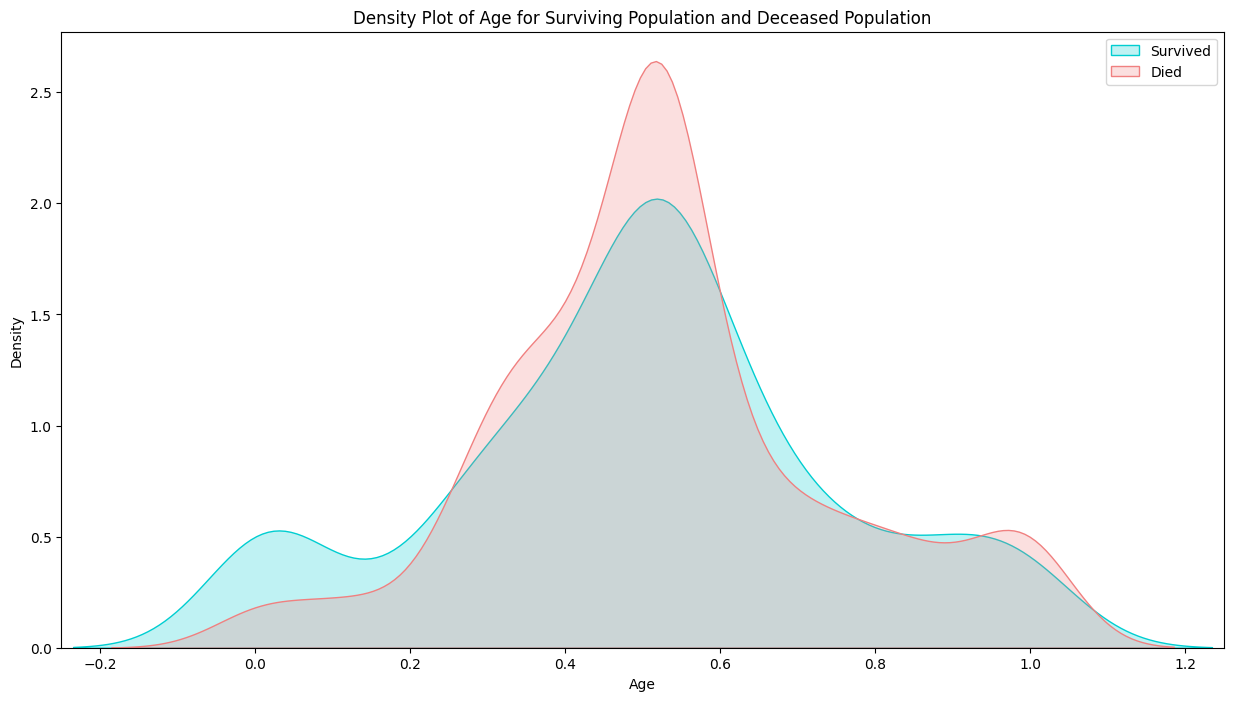

In [4]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(df["age"][df.survived == 1], color="darkturquoise", fill=True)
sns.kdeplot(df["age"][df.survived == 0], color="lightcoral", fill=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='Age')
plt.xlim(-0.25,1.25)
plt.show()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

print(f'shape of train feature set:{X_train.shape}\t\tshape of train target set:{y_train.shape}\n')
print(f'shape of test feature set:{X_test.shape}\t\tshape of test target set:{y_test.shape}\n')

shape of train feature set:(668, 27)		shape of train target set:(668,)

shape of test feature set:(223, 27)		shape of test target set:(223,)



In [25]:
model = LogisticRegression(C=0.1,max_iter=5000)
cv = KFold(n_splits=5, random_state=42, shuffle=True)

scoring = ['accuracy', 'precision', 'recall', 'f1']
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)

# Calculate average cross-validation scores
average_scores = {metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring}

In [26]:
print("Average Cross-Validation Metrics:")
print(f"Accuracy: {average_scores['accuracy']:.2f}")
print(f"Precision: {average_scores['precision']:.2f}")
print(f"Recall: {average_scores['recall']:.2f}")
print(f"F1 Score: {average_scores['f1']:.2f}")

Average Cross-Validation Metrics:
Accuracy: 0.80
Precision: 0.81
Recall: 0.63
F1 Score: 0.71


In [27]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

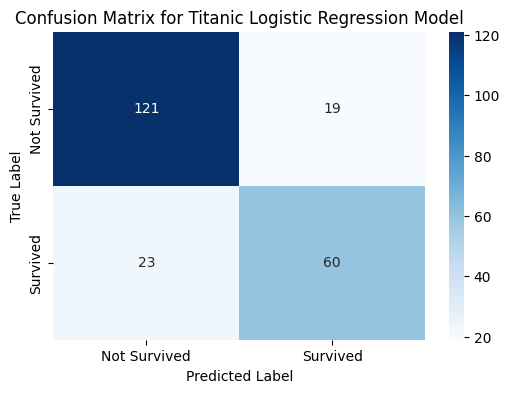

In [28]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Titanic Logistic Regression Model")
plt.show()

In [29]:
# Calculate evaluation metrics for test dataset
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

In [30]:
print("Test Dataset Evaluation Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1 Score: {test_f1:.2f}")

Test Dataset Evaluation Metrics:
Accuracy: 0.81
Precision: 0.76
Recall: 0.72
F1 Score: 0.74


# Grid Searcch tuning

In [52]:
param_grid = {
    "C": [0.01,0.005,0.05, 0.1,0.5, 1, 10, 100],  # Regularization strength
    "solver": [ "liblinear", "saga"],  # Solvers
    "penalty": ["l1", "l2"],  # Regularization type
}
model = LogisticRegression(max_iter=3000)
# Set up GridSearchCV with multiple scoring metrics and 5-fold cross-validation
grid_search = GridSearchCV(
    model, param_grid=param_grid, cv=cv, scoring=scoring, refit="precision", n_jobs=-1
)
#Initialize SMOTE and apply it to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Fit grid search to training data
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=3000), n_jobs=-1,
             param_grid={'C': [0.01, 0.005, 0.05, 0.1, 0.5, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             refit='precision',
             scoring=['accuracy', 'precision', 'recall', 'f1'])

In [53]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

In [54]:
print("Best Parameters:", best_params)
print(f"Best F1 Score from Grid Search (cross-validated): {best_f1_score:.2f}")


Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Best F1 Score from Grid Search (cross-validated): 0.84


In [55]:
# Evaluate the Best Model on Test Data
y_pred_best = best_model.predict(X_test)
# Calculate test metrics for the best model
test_accuracy = accuracy_score(y_test, y_pred_best)
test_precision = precision_score(y_test, y_pred_best)
test_recall = recall_score(y_test, y_pred_best)
test_f1 = f1_score(y_test, y_pred_best)

In [56]:
print("\nTest Dataset Evaluation Metrics (Best Model):")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1 Score: {test_f1:.2f}")


Test Dataset Evaluation Metrics (Best Model):
Accuracy: 0.80
Precision: 0.72
Recall: 0.76
F1 Score: 0.74


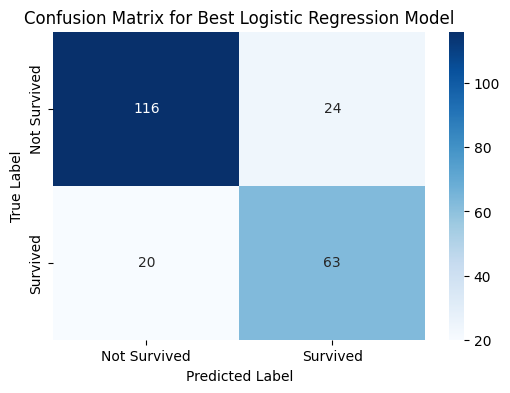

In [57]:
# Confusion Matrix for Best Model
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Best Logistic Regression Model")
plt.show()

In [59]:
pd.Series(y_test).value_counts()

survived
0.0    140
1.0     83
Name: count, dtype: int64

In [60]:
pd.Series(y_pred_best).value_counts()

0.0    136
1.0     87
Name: count, dtype: int64

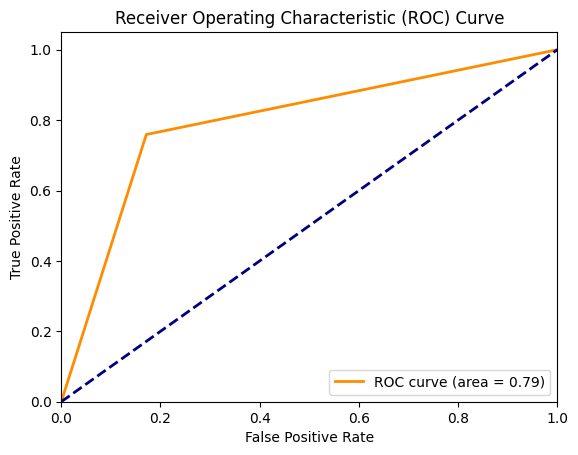

In [68]:
from sklearn.metrics import roc_curve, auc
y_test = y_test.astype(int)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_best)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()